### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/13_lifestyle_intervention/alabama/2023_04_20_10_07_48/count_data

deaths.csv                       sbp_medication_person_time.csv
deaths.hdf                       sbp_medication_person_time.hdf
healthcare_visits.csv            state_person_time.csv
healthcare_visits.hdf            state_person_time.hdf
intervention_person_time.csv     transition_count.csv
intervention_person_time.hdf     transition_count.hdf
ldlc_medication_person_time.csv  ylds.csv
ldlc_medication_person_time.hdf  ylds.hdf
risk_exposure_time.csv           ylls.csv
risk_exposure_time.hdf           ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/13_lifestyle_intervention/alabama/2023_04_20_10_07_48/count_data/'

### Exploring Data

In [4]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,female,2023,acute_ischemic_stroke,deaths,29,baseline,25_to_29,1.0
1,1,female,2023,acute_ischemic_stroke,deaths,29,lifestyle_100,25_to_29,1.0
2,2,female,2023,acute_ischemic_stroke,deaths,29,lifestyle_50,25_to_29,1.0
3,3,female,2023,acute_ischemic_stroke,deaths,29,outreach_100,25_to_29,1.0
4,4,female,2023,acute_ischemic_stroke,deaths,29,outreach_50,25_to_29,1.0


In [5]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

709750357.9356605

In [6]:
person_time_test = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
person_time_test.value.sum()

709750357.9356606

### All Cause Mortality Graphs

In [7]:
deaths_all = deaths.groupby(['age', 'sex', 'year','scenario','input_draw']).value.sum().reset_index()
deaths_all.head()

,age,sex,year,scenario,input_draw,value
0,25_to_29,female,2023,baseline,29,43.0
1,25_to_29,female,2023,baseline,232,29.0
2,25_to_29,female,2023,baseline,357,28.0
3,25_to_29,female,2023,baseline,394,29.0
4,25_to_29,female,2023,baseline,602,43.0


In [8]:
result_summary = (deaths_all
                      .groupby(['age', 'sex', 'year','scenario'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,35.3,25.675,46.325
1,25_to_29,female,2023,lifestyle_100,35.3,25.675,46.325
2,25_to_29,female,2023,lifestyle_50,35.3,25.675,46.325
3,25_to_29,female,2023,outreach_100,35.3,25.675,46.325
4,25_to_29,female,2023,outreach_50,35.3,25.675,46.325


In [9]:
%%capture 
from matplotlib.backends.backend_pdf import PdfPages # PDF package

with PdfPages('model13vv_raw_mortality_counts.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure()             
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Raw death counts: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=1000)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [10]:
deaths_all = deaths.groupby(['sex', 'year','scenario','input_draw']).value.sum().reset_index()
result_summary = (deaths_all
                      .groupby(['sex', 'year','scenario'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,sex,year,scenario,mean,2.5%,97.5%
0,female,2023,baseline,4603.8,4075.550,5121.300
1,female,2023,lifestyle_100,4603.7,4075.550,5120.525
2,female,2023,lifestyle_50,4603.8,4075.550,5121.300
3,female,2023,outreach_100,4601.3,4073.875,5118.525
4,female,2023,outreach_50,4602.8,4075.100,5120.850


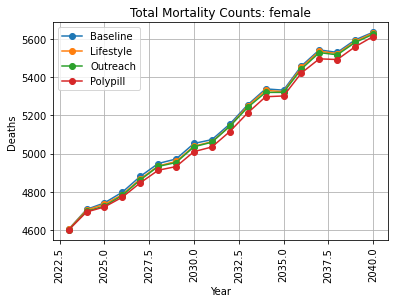

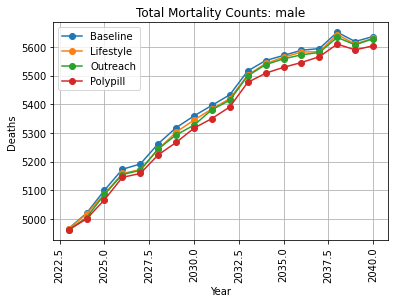

In [11]:
with PdfPages('model13_count_mortality_byyear.pdf') as pdf:
    for sex in result_summary.sex.unique():
        plt.figure() 
        subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
        plt.title(f'Total Mortality Counts: {sex}') 
        plt.xticks(rotation=90) 
        plt.ylabel('Deaths')
        plt.xlabel('Year')
        #plt.ylim(ymax=1000)
        plt.grid()
        pdf.savefig(bbox_inches='tight')

#### All Cause Mortality Graph with Rate

In [12]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()

per_time_group.head()

,age,sex,year,input_draw,scenario,ptvalue
0,25_to_29,female,2023,29,baseline,27454.412047
1,25_to_29,female,2023,29,lifestyle_100,27454.412047
2,25_to_29,female,2023,29,lifestyle_50,27454.412047
3,25_to_29,female,2023,29,outreach_100,27454.412047
4,25_to_29,female,2023,29,outreach_50,27454.412047


In [13]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw','scenario']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.001281,0.000932,0.001678
1,25_to_29,female,2023,lifestyle_100,0.001281,0.000932,0.001678
2,25_to_29,female,2023,lifestyle_50,0.001281,0.000932,0.001678
3,25_to_29,female,2023,outreach_100,0.001281,0.000932,0.001678
4,25_to_29,female,2023,outreach_50,0.001281,0.000932,0.001678


In [14]:
%%capture 
with PdfPages('model13_acmr.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year) & (result_summary.scenario=='baseline')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year) & (result_summary.scenario=='lifestyle_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year) & (result_summary.scenario=='outreach_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year) & (result_summary.scenario=='polypill_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.title(f'All Cause Mortality Rate: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.4)
            plt.grid()
            plt.xlabel('Age')
            plt.ylabel('Deaths per Person/Year')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            pdf.savefig(bbox_inches='tight')

In [15]:
%%capture
## Has age and year reversed, so looking at year trend by age group now. 
with PdfPages('model13_acmr_byyear.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for age in result_summary.age.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age) & (result_summary.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha =0.3)
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age) & (result_summary.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha =0.3)
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age) & (result_summary.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha =0.3)
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age) & (result_summary.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha =0.3)
            plt.title(f'ACMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            #plt.ylim(ymax=0.1)
            plt.grid()
            plt.xlabel('Years')
            plt.ylabel('Deaths per Person/Year')
            plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
            pdf.savefig(bbox_inches='tight')

In [16]:
result_summary_allage = (results_rate
                      .groupby(['sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allage.head()

,sex,year,scenario,mean,2.5%,97.5%
0,female,2023,baseline,0.050158,0.001054,0.284824
1,female,2023,lifestyle_100,0.050158,0.001054,0.284824
2,female,2023,lifestyle_50,0.050158,0.001054,0.284824
3,female,2023,outreach_100,0.050120,0.001054,0.284824
4,female,2023,outreach_50,0.050150,0.001054,0.284824


In [17]:
%%capture
with PdfPages('model13_acmr_allages.pdf') as pdf:
    for sex in result_summary_allage.sex.unique():
        plt.figure() 
        subdata = result_summary_allage.loc[(result_summary_allage.sex==sex) & (result_summary_allage.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = result_summary_allage.loc[(result_summary_allage.sex==sex) & (result_summary_allage.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = result_summary_allage.loc[(result_summary_allage.sex==sex) & (result_summary_allage.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = result_summary_allage.loc[(result_summary_allage.sex==sex) & (result_summary_allage.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.title(f'ACMR: {sex}') 
        plt.xticks(rotation=90) 
        #plt.ylim(ymax=0.1)
        plt.grid()
        plt.xlabel('Years')
        plt.ylabel('Deaths per Person/Year')
        plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
        pdf.savefig(bbox_inches='tight')

In [18]:
result_summary_allsex = (results_rate
                      .groupby(['age', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allsex.head()

,age,year,scenario,mean,2.5%,97.5%
0,25_to_29,2023,baseline,0.002089,0.000958,0.003865
1,25_to_29,2023,lifestyle_100,0.002089,0.000958,0.003865
2,25_to_29,2023,lifestyle_50,0.002089,0.000958,0.003865
3,25_to_29,2023,outreach_100,0.002089,0.000958,0.003865
4,25_to_29,2023,outreach_50,0.002089,0.000958,0.003865


In [19]:
%%capture
with PdfPages('model13_acmr_allsex.pdf') as pdf:
    for age in result_summary_allsex.age.unique():
        plt.figure() 
        subdata = result_summary_allsex.loc[(result_summary_allsex.age==age) & (result_summary_allsex.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = result_summary_allsex.loc[(result_summary_allsex.age==age) & (result_summary_allsex.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = result_summary_allsex.loc[(result_summary_allsex.age==age) & (result_summary_allsex.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = result_summary_allsex.loc[(result_summary_allsex.age==age) & (result_summary_allsex.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.title(f'ACMR: {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(ymax=0.1)
        plt.grid()
        plt.xlabel('Years')
        plt.ylabel('Deaths per Person/Year')
        plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
        pdf.savefig(bbox_inches='tight')

## Count Mortality 

#### All Stroke

In [20]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause','scenario']).value.sum().reset_index()
stroke_rate = death_rate_cause.loc[(death_rate_cause['cause'].isin(['chronic_ischemic_stroke','acute_ischemic_stroke']))].reset_index()
stroke_rate = stroke_rate.groupby(['sex', 'year','scenario','input_draw']).value.sum().reset_index()
stroke_rate_summ = (stroke_rate
                      .groupby(['sex', 'year','scenario'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

stroke_rate_summ.head()

,sex,year,scenario,mean,2.5%,97.5%
0,female,2023,baseline,215.8,189.675,269.050
1,female,2023,lifestyle_100,215.8,189.675,269.050
2,female,2023,lifestyle_50,215.8,189.675,269.050
3,female,2023,outreach_100,215.9,189.675,269.275
4,female,2023,outreach_50,215.8,189.675,269.050


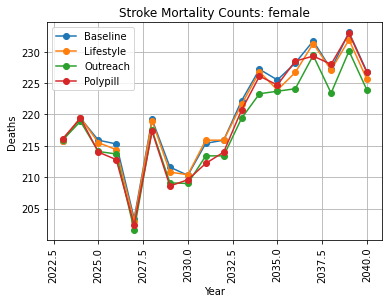

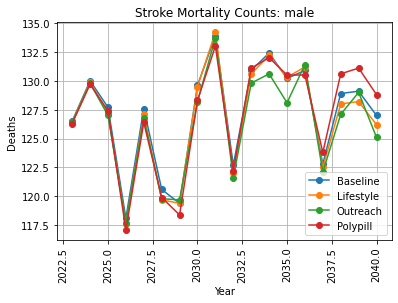

In [21]:
#%%capture
with PdfPages('model13_stroke_mortality_counts.pdf') as pdf:
    for sex in stroke_rate_summ.sex.unique():
        plt.figure() 
        subdata = stroke_rate_summ.loc[(stroke_rate_summ.sex==sex) & (stroke_rate_summ.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = stroke_rate_summ.loc[(stroke_rate_summ.sex==sex) & (stroke_rate_summ.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = stroke_rate_summ.loc[(stroke_rate_summ.sex==sex) & (stroke_rate_summ.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = stroke_rate_summ.loc[(stroke_rate_summ.sex==sex) & (stroke_rate_summ.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
        plt.title(f'Stroke Mortality Counts: {sex}') 
        plt.xticks(rotation=90) 
        plt.xlabel('Year')
        plt.ylabel('Deaths')
        plt.grid()
        pdf.savefig(bbox_inches='tight')

#### All IHD

In [22]:
IHD_rate = death_rate_cause.loc[(death_rate_cause['cause'].isin(['acute_myocardial_infarction','acute_myocardial_infarction_and_heart_failure','heart_failure_from_ischemic_heart_disease','heart_failure_residual','post_myocardial_infarction']))].reset_index()
IHD_rate = IHD_rate.groupby(['sex', 'year','scenario','input_draw']).value.sum().reset_index()
IHD_rate_summ = (IHD_rate
                      .groupby(['sex', 'year','scenario'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

IHD_rate_summ.head()

,sex,year,scenario,mean,2.5%,97.5%
0,female,2023,baseline,2765.4,2380.6,3086.000
1,female,2023,lifestyle_100,2765.3,2380.6,3086.000
2,female,2023,lifestyle_50,2765.4,2380.6,3086.000
3,female,2023,outreach_100,2762.7,2378.6,3083.325
4,female,2023,outreach_50,2764.4,2379.6,3085.550


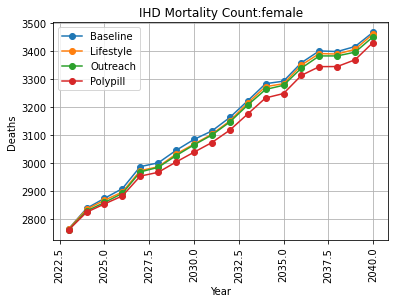

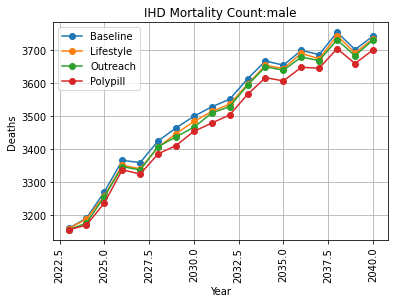

In [23]:
#%%capture
with PdfPages('model13_IHD_mortality_count.pdf') as pdf:
    for sex in IHD_rate_summ.sex.unique():
        plt.figure() 
        subdata = IHD_rate_summ.loc[(IHD_rate_summ.sex==sex) & (IHD_rate_summ.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = IHD_rate_summ.loc[(IHD_rate_summ.sex==sex) & (IHD_rate_summ.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = IHD_rate_summ.loc[(IHD_rate_summ.sex==sex) & (IHD_rate_summ.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = IHD_rate_summ.loc[(IHD_rate_summ.sex==sex) & (IHD_rate_summ.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
        plt.title(f'IHD Mortality Count:{sex}') 
        plt.xticks(rotation=90) 
        plt.xlabel('Year')
        plt.ylabel('Deaths')
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### Cause Specific Mortality Graphs

### CSMR for All Stroke

In [24]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause','scenario']).value.sum().reset_index()
stroke_rate = death_rate_cause.loc[(death_rate_cause['cause'].isin(['chronic_ischemic_stroke','acute_ischemic_stroke']))].reset_index()
stroke_rate = stroke_rate.groupby(['age', 'sex', 'year','scenario','input_draw']).value.sum().reset_index()
stroke_rate = stroke_rate.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue']], on=['age','sex','year','input_draw', 'scenario'])
stroke_rate['mean_rate'] = stroke_rate['value'] / stroke_rate['ptvalue']
stroke_rate_summ = (stroke_rate
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

stroke_rate_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000015,0.0,0.000036
1,25_to_29,female,2023,lifestyle_100,0.000015,0.0,0.000036
2,25_to_29,female,2023,lifestyle_50,0.000015,0.0,0.000036
3,25_to_29,female,2023,outreach_100,0.000015,0.0,0.000036
4,25_to_29,female,2023,outreach_50,0.000015,0.0,0.000036


In [25]:
%%capture
with PdfPages('model13_stroke_csmr.pdf') as pdf:
    for sex in stroke_rate_summ.sex.unique():
        for age in stroke_rate_summ.age.unique():
            plt.figure() 
            subdata = stroke_rate_summ.loc[(stroke_rate_summ.sex==sex) & (stroke_rate_summ.age==age) & (stroke_rate_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = stroke_rate_summ.loc[(stroke_rate_summ.sex==sex) & (stroke_rate_summ.age==age) & (stroke_rate_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = stroke_rate_summ.loc[(stroke_rate_summ.sex==sex) & (stroke_rate_summ.age==age) & (stroke_rate_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = stroke_rate_summ.loc[(stroke_rate_summ.sex==sex) & (stroke_rate_summ.age==age) & (stroke_rate_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'Stroke CSMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.xlabel('Year')
            plt.ylabel('Deaths per Person/Year')
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [26]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause','scenario']).value.sum().reset_index()
stroke_rate = death_rate_cause.loc[(death_rate_cause['cause'].isin(['chronic_ischemic_stroke','acute_ischemic_stroke']))].reset_index()
stroke_rate = stroke_rate.groupby(['sex', 'year','scenario','input_draw']).value.sum().reset_index()
per_time_group_age = per_time_group.groupby(['sex', 'year','scenario','input_draw']).ptvalue.sum().reset_index()
stroke_rate = stroke_rate.merge(per_time_group[['sex','year','input_draw','scenario','ptvalue']], on=['sex','year','input_draw', 'scenario'])
stroke_rate['mean_rate'] = stroke_rate['value'] / stroke_rate['ptvalue']
stroke_rate_summ = (stroke_rate
                      .groupby(['sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

stroke_rate_summ.head()

,sex,year,scenario,mean,2.5%,97.5%
0,female,2023,baseline,0.026803,0.006945,0.169493
1,female,2023,lifestyle_100,0.026803,0.006945,0.169493
2,female,2023,lifestyle_50,0.026803,0.006945,0.169493
3,female,2023,outreach_100,0.026815,0.006945,0.169475
4,female,2023,outreach_50,0.026803,0.006945,0.169481


In [27]:
%%capture
with PdfPages('model13_stroke_csmr_allages.pdf') as pdf:
    for sex in stroke_rate_summ.sex.unique():
        plt.figure() 
        subdata = stroke_rate_summ.loc[(stroke_rate_summ.sex==sex) & (stroke_rate_summ.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = stroke_rate_summ.loc[(stroke_rate_summ.sex==sex) & (stroke_rate_summ.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = stroke_rate_summ.loc[(stroke_rate_summ.sex==sex) & (stroke_rate_summ.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = stroke_rate_summ.loc[(stroke_rate_summ.sex==sex) & (stroke_rate_summ.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
        plt.title(f'Stroke CSMR:{sex}') 
        plt.xticks(rotation=90) 
        plt.xlabel('Year')
        plt.ylabel('Deaths per Person/Year')
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### CSMR for All IHD 

In [28]:
IHD_rate = death_rate_cause.loc[(death_rate_cause['cause'].isin(['acute_myocardial_infarction','acute_myocardial_infarction_and_heart_failure','heart_failure_from_ischemic_heart_disease','heart_failure_residual','post_myocardial_infarction']))].reset_index()
IHD_rate = IHD_rate.groupby(['age', 'sex', 'year','scenario','input_draw']).value.sum().reset_index()
IHD_rate = IHD_rate.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue']], on=['age','sex','year','input_draw', 'scenario'])
IHD_rate['mean_rate'] = IHD_rate['value'] / IHD_rate['ptvalue']
IHD_rate_summ = (IHD_rate
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

IHD_rate_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000842,0.000532,0.001142
1,25_to_29,female,2023,lifestyle_100,0.000842,0.000532,0.001142
2,25_to_29,female,2023,lifestyle_50,0.000842,0.000532,0.001142
3,25_to_29,female,2023,outreach_100,0.000842,0.000532,0.001142
4,25_to_29,female,2023,outreach_50,0.000842,0.000532,0.001142


In [29]:
%%capture
with PdfPages('model13_IHD_csmr.pdf') as pdf:
    for sex in IHD_rate_summ.sex.unique():
        for age in IHD_rate_summ.age.unique():
            plt.figure() 
            subdata = IHD_rate_summ.loc[(IHD_rate_summ.sex==sex) & (IHD_rate_summ.age==age) & (IHD_rate_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_rate_summ.loc[(IHD_rate_summ.sex==sex) & (IHD_rate_summ.age==age) & (IHD_rate_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_rate_summ.loc[(IHD_rate_summ.sex==sex) & (IHD_rate_summ.age==age) & (IHD_rate_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_rate_summ.loc[(IHD_rate_summ.sex==sex) & (IHD_rate_summ.age==age) & (IHD_rate_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'IHD CSMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.xlabel('Year')
            plt.ylabel('Deaths per Person/Year')
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [30]:
IHD_rate = death_rate_cause.loc[(death_rate_cause['cause'].isin(['acute_myocardial_infarction','acute_myocardial_infarction_and_heart_failure','heart_failure_from_ischemic_heart_disease','heart_failure_residual','post_myocardial_infarction']))].reset_index()
IHD_rate = IHD_rate.groupby(['sex', 'year','scenario','input_draw']).value.sum().reset_index()
IHD_rate = IHD_rate.merge(per_time_group_age[['sex','year','input_draw','scenario','ptvalue']], on=['sex','year','input_draw', 'scenario'])
IHD_rate['mean_rate'] = IHD_rate['value'] / IHD_rate['ptvalue']
IHD_rate_summ = (IHD_rate
                      .groupby(['sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

IHD_rate_summ.head()

,sex,year,scenario,mean,2.5%,97.5%
0,female,2023,baseline,0.009407,0.008100,0.010531
1,female,2023,lifestyle_100,0.009406,0.008100,0.010531
2,female,2023,lifestyle_50,0.009407,0.008100,0.010531
3,female,2023,outreach_100,0.009398,0.008094,0.010521
4,female,2023,outreach_50,0.009403,0.008097,0.010525


In [31]:
%%capture
with PdfPages('model13_IHD_csmr_allages.pdf') as pdf:
    for sex in IHD_rate_summ.sex.unique():
            plt.figure() 
            subdata = IHD_rate_summ.loc[(IHD_rate_summ.sex==sex) & (IHD_rate_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_rate_summ.loc[(IHD_rate_summ.sex==sex) & (IHD_rate_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_rate_summ.loc[(IHD_rate_summ.sex==sex) & (IHD_rate_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_rate_summ.loc[(IHD_rate_summ.sex==sex) & (IHD_rate_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'IHD CSMR: {sex}') 
            plt.xticks(rotation=90) 
            plt.xlabel('Year')
            plt.ylabel('Deaths per Person/Year')
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Excess Mortality rate

### All IHD EMR

In [33]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw','scenario']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_IHD = per_time_state.loc[(per_time_state['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction"]))].reset_index()
per_time_IHD = per_time_IHD.groupby(['age','sex','year','input_draw','scenario']).ptvalue.sum().reset_index()
IHD_emr = death_rate_cause.loc[(death_rate_cause['cause'].isin(['heart_failure_from_ischemic_heart_disease','heart_failure_residual','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','acute_myocardial_infarction_and_heart_failure','acute_myocardial_infarction']))].reset_index()
IHD_emr = IHD_emr.groupby(['age','sex','year','input_draw','scenario']).value.sum().reset_index()
IHD_emr = IHD_emr.merge(per_time_IHD[['age','sex','year','input_draw','scenario','ptvalue']], on=['age','sex','year','input_draw','scenario'])
IHD_emr['mean_rate'] = IHD_emr['value'] / IHD_emr['ptvalue']
IHD_emr_summ = (IHD_emr
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

IHD_emr_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.138928,0.100249,0.196175
1,25_to_29,female,2023,lifestyle_100,0.138928,0.100249,0.196175
2,25_to_29,female,2023,lifestyle_50,0.138928,0.100249,0.196175
3,25_to_29,female,2023,outreach_100,0.138982,0.100249,0.196175
4,25_to_29,female,2023,outreach_50,0.138982,0.100249,0.196175


In [34]:
%%capture
with PdfPages('model13_IHD_emr.pdf') as pdf:
    for sex in IHD_emr_summ.sex.unique():
        for age in IHD_emr_summ.age.unique():
            plt.figure() 
            subdata = IHD_emr_summ.loc[(IHD_emr_summ.sex==sex) & (IHD_emr_summ.age==age) & (IHD_emr_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_emr_summ.loc[(IHD_emr_summ.sex==sex) & (IHD_emr_summ.age==age) & (IHD_emr_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_emr_summ.loc[(IHD_emr_summ.sex==sex) & (IHD_emr_summ.age==age) & (IHD_emr_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_emr_summ.loc[(IHD_emr_summ.sex==sex) & (IHD_emr_summ.age==age) & (IHD_emr_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'IHD EMR: {age} {sex}') 
            plt.xlabel('Year')
            plt.ylabel('Death per Person/Year')
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [35]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw','scenario']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_IHD = per_time_state.loc[(per_time_state['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction"]))].reset_index()
per_time_IHD = per_time_IHD.groupby(['sex','year','input_draw','scenario']).ptvalue.sum().reset_index()
IHD_emr = death_rate_cause.loc[(death_rate_cause['cause'].isin(['heart_failure_from_ischemic_heart_disease','heart_failure_residual','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','acute_myocardial_infarction_and_heart_failure','acute_myocardial_infarction']))].reset_index()
IHD_emr = IHD_emr.groupby(['sex','year','input_draw','scenario']).value.sum().reset_index()
IHD_emr = IHD_emr.merge(per_time_IHD[['sex','year','input_draw','scenario','ptvalue']], on=['sex','year','input_draw','scenario'])
IHD_emr['mean_rate'] = IHD_emr['value'] / IHD_emr['ptvalue']
IHD_emr_summ = (IHD_emr
                      .groupby(['sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

IHD_emr_summ.head()

,sex,year,scenario,mean,2.5%,97.5%
0,female,2023,baseline,0.175170,0.149931,0.194699
1,female,2023,lifestyle_100,0.175167,0.149933,0.194643
2,female,2023,lifestyle_50,0.175172,0.149932,0.194702
3,female,2023,outreach_100,0.175023,0.149798,0.194551
4,female,2023,outreach_50,0.175124,0.149875,0.194722


In [36]:
%%capture
with PdfPages('model13_IHD_emr_allages.pdf') as pdf:
    for sex in IHD_emr_summ.sex.unique():
            plt.figure() 
            subdata = IHD_emr_summ.loc[(IHD_emr_summ.sex==sex) & (IHD_emr_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_emr_summ.loc[(IHD_emr_summ.sex==sex) & (IHD_emr_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_emr_summ.loc[(IHD_emr_summ.sex==sex) & (IHD_emr_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_emr_summ.loc[(IHD_emr_summ.sex==sex) & (IHD_emr_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'IHD EMR:{sex}') 
            plt.xlabel('Year')
            plt.ylabel('Death per Person/Year')
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### All Stroke EMR

In [37]:
per_time_stroke = per_time_state.loc[(per_time_state['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke"]))].reset_index()
per_time_stroke = per_time_stroke.groupby(['age','sex','year','input_draw','scenario']).ptvalue.sum().reset_index()
stroke_emr = death_rate_cause.loc[(death_rate_cause['cause'].isin(['acute_ischemic_stroke','chronic_ischemic_stroke']))].reset_index()
stroke_emr = stroke_emr.groupby(['age','sex','year','input_draw','scenario']).value.sum().reset_index()
stroke_emr = stroke_emr.merge(per_time_stroke[['age','sex','year','input_draw','scenario','ptvalue']], on=['age','sex','year','input_draw','scenario'])
stroke_emr['mean_rate'] = stroke_emr['value'] / stroke_emr['ptvalue']
stroke_emr_summ = (stroke_emr
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

stroke_emr_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.002419,0.0,0.006706
1,25_to_29,female,2023,lifestyle_100,0.002419,0.0,0.006706
2,25_to_29,female,2023,lifestyle_50,0.002419,0.0,0.006706
3,25_to_29,female,2023,outreach_100,0.002419,0.0,0.006706
4,25_to_29,female,2023,outreach_50,0.002419,0.0,0.006706


In [38]:
%%capture
with PdfPages('model13_stroke_emr.pdf') as pdf:
    for sex in stroke_emr_summ.sex.unique():
        for age in stroke_emr_summ.age.unique():
            plt.figure() 
            subdata = stroke_emr_summ.loc[(stroke_emr_summ.sex==sex) & (stroke_emr_summ.age==age) & (stroke_emr_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = stroke_emr_summ.loc[(stroke_emr_summ.sex==sex) & (stroke_emr_summ.age==age) & (stroke_emr_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = stroke_emr_summ.loc[(stroke_emr_summ.sex==sex) & (stroke_emr_summ.age==age) & (stroke_emr_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = stroke_emr_summ.loc[(stroke_emr_summ.sex==sex) & (stroke_emr_summ.age==age) & (stroke_emr_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'Stroke EMR: {age} {sex}') 
            plt.xlabel('Year')
            plt.ylabel('Death per Person/Year')
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [39]:
per_time_stroke = per_time_state.loc[(per_time_state['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke"]))].reset_index()
per_time_stroke = per_time_stroke.groupby(['sex','year','input_draw','scenario']).ptvalue.sum().reset_index()
stroke_emr = death_rate_cause.loc[(death_rate_cause['cause'].isin(['acute_ischemic_stroke','chronic_ischemic_stroke']))].reset_index()
stroke_emr = stroke_emr.groupby(['sex','year','input_draw','scenario']).value.sum().reset_index()
stroke_emr = stroke_emr.merge(per_time_stroke[['sex','year','input_draw','scenario','ptvalue']], on=['sex','year','input_draw','scenario'])
stroke_emr['mean_rate'] = stroke_emr['value'] / stroke_emr['ptvalue']
stroke_emr_summ = (stroke_emr
                      .groupby(['sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

stroke_emr_summ.head()

,sex,year,scenario,mean,2.5%,97.5%
0,female,2023,baseline,0.020072,0.017125,0.028870
1,female,2023,lifestyle_100,0.020073,0.017125,0.028870
2,female,2023,lifestyle_50,0.020072,0.017125,0.028870
3,female,2023,outreach_100,0.020083,0.017126,0.028893
4,female,2023,outreach_50,0.020073,0.017126,0.028871


In [40]:
%%capture
with PdfPages('model13_stroke_emr_allages.pdf') as pdf:
    for sex in stroke_emr_summ.sex.unique():
            plt.figure() 
            subdata = stroke_emr_summ.loc[(stroke_emr_summ.sex==sex) & (stroke_emr_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = stroke_emr_summ.loc[(stroke_emr_summ.sex==sex) & (stroke_emr_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = stroke_emr_summ.loc[(stroke_emr_summ.sex==sex) & (stroke_emr_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = stroke_emr_summ.loc[(stroke_emr_summ.sex==sex) & (stroke_emr_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'Stroke EMR: {sex}') 
            plt.xlabel('Year')
            plt.ylabel('Death per Person/Year')
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Incidence of First Time Acute Ischemic Stroke

In [41]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')
tran.head()

,Unnamed: 0,sex,year,measure,input_draw,scenario,age,transition,value
0,0,female,2023,transition_count,29,baseline,25_to_29,ischemic_heart_disease_and_heart_failure_acute...,0.0
1,1,female,2023,transition_count,29,lifestyle_100,25_to_29,ischemic_heart_disease_and_heart_failure_acute...,0.0
2,2,female,2023,transition_count,29,lifestyle_50,25_to_29,ischemic_heart_disease_and_heart_failure_acute...,0.0
3,3,female,2023,transition_count,29,outreach_100,25_to_29,ischemic_heart_disease_and_heart_failure_acute...,0.0
4,4,female,2023,transition_count,29,outreach_50,25_to_29,ischemic_heart_disease_and_heart_failure_acute...,0.0


In [42]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition','scenario'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

,index,age,sex,year,transition,scenario,mean,2.5%,97.5%
0,70,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,baseline,9.2,0.225,22.875
1,71,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,lifestyle_100,9.2,0.225,22.875
2,72,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,lifestyle_50,9.2,0.225,22.875
3,73,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,outreach_100,9.2,0.225,22.875
4,74,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,outreach_50,9.2,0.225,22.875


In [43]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

,index,age,sex,year,state,input_draw,scenario,ptvalue
0,560,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,baseline,27249.423682
1,561,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,lifestyle_100,27249.423682
2,562,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,lifestyle_50,27249.423682
3,563,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,outreach_100,27249.423682
4,564,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,outreach_50,27249.423682


In [44]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw','scenario']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year','scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000334,0.000008,0.000832
1,25_to_29,female,2023,lifestyle_100,0.000334,0.000008,0.000832
2,25_to_29,female,2023,lifestyle_50,0.000334,0.000008,0.000832
3,25_to_29,female,2023,outreach_100,0.000334,0.000008,0.000832
4,25_to_29,female,2023,outreach_50,0.000334,0.000008,0.000832


In [45]:
%%capture
with PdfPages('model13_acute_stroke_inc.pdf') as pdf:
    for sex in tran_rate_sum.sex.unique():
        for age in tran_rate_sum.age.unique():
            plt.figure() 
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.age==age) & (tran_rate_sum.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.age==age) & (tran_rate_sum.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.age==age) & (tran_rate_sum.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.age==age) & (tran_rate_sum.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'Acute Stroke Incidence: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.xlabel('Year')
            plt.ylabel('Stroke Events per 100_000 Person Years')
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [46]:
tran_rate = tran.groupby(['sex', 'year', 'transition', 'input_draw','scenario']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
per_time_group_age = per_time_group.groupby(['sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
tran_rate = pd.concat([tran_rate, per_time_group_age.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['sex', 'year','scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,sex,year,scenario,mean,2.5%,97.5%
0,female,2023,baseline,0.001913,0.001577,0.002364
1,female,2023,lifestyle_100,0.001911,0.001577,0.002364
2,female,2023,lifestyle_50,0.001913,0.001577,0.002364
3,female,2023,outreach_100,0.001899,0.001567,0.002347
4,female,2023,outreach_50,0.001907,0.001574,0.002358


In [47]:
%%capture
with PdfPages('model13_acute_stroke_inc_allages.pdf') as pdf:
    for sex in tran_rate_sum.sex.unique():
            plt.figure() 
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'Acute Stroke Incidence: {sex}') 
            plt.xticks(rotation=90) 
            plt.xlabel('Year')
            plt.ylabel('Stroke Events per 100_000 Person Years')
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Incidence of First Time Acute MI

In [48]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw','scenario']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_first_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_first_MI_summ.head()

mean      2.5%     97.5%
age      sex    year scenario                                   
25_to_29 female 2023 baseline       0.000848  0.000133  0.001859
                     lifestyle_100  0.000848  0.000133  0.001859
                     lifestyle_50   0.000848  0.000133  0.001859
                     outreach_100   0.000848  0.000133  0.001859
                     outreach_50    0.000848  0.000133  0.001859

In [49]:
%%capture
with PdfPages('model13_first_time_acute_MI_inc.pdf') as pdf:
    for sex in tran_first_MI_summ.index.get_level_values('sex').unique():
        for age in tran_first_MI_summ.index.get_level_values('age').unique():
            plt.figure() 
            subdata = tran_first_MI_summ.loc[(tran_first_MI_summ.index.get_level_values('sex')==sex) & (tran_first_MI_summ.index.get_level_values('age')==age) & (tran_first_MI_summ.index.get_level_values('scenario')=='baseline')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_first_MI_summ.loc[(tran_first_MI_summ.index.get_level_values('sex')==sex) & (tran_first_MI_summ.index.get_level_values('age')==age) & (tran_first_MI_summ.index.get_level_values('scenario')=='lifestyle_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_first_MI_summ.loc[(tran_first_MI_summ.index.get_level_values('sex')==sex) & (tran_first_MI_summ.index.get_level_values('age')==age) & (tran_first_MI_summ.index.get_level_values('scenario')=='outreach_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_first_MI_summ.loc[(tran_first_MI_summ.index.get_level_values('sex')==sex) & (tran_first_MI_summ.index.get_level_values('age')==age) & (tran_first_MI_summ.index.get_level_values('scenario')=='polypill_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'First Time Acute MI Incidence: {sex} {age}') 
            plt.xticks(rotation=90) 
            plt.xlabel('Year')
            plt.ylabel('MI Events per 100_000 Person Years')
            plt.grid()
            #plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

In [50]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['sex', 'year', 'input_draw','scenario']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_first_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_first_MI_summ.head()

mean      2.5%     97.5%
sex    year scenario                                   
female 2023 baseline       0.002934  0.002215  0.003865
            lifestyle_100  0.002932  0.002215  0.003862
            lifestyle_50   0.002933  0.002215  0.003865
            outreach_100   0.002906  0.002178  0.003848
            outreach_50    0.002921  0.002199  0.003853

In [51]:
%%capture
with PdfPages('model13_first_time_acute_MI_inc_allages.pdf') as pdf:
    for sex in tran_first_MI_summ.index.get_level_values('sex').unique():
            plt.figure() 
            subdata = tran_first_MI_summ.loc[(tran_first_MI_summ.index.get_level_values('sex')==sex) & (tran_first_MI_summ.index.get_level_values('scenario')=='baseline')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_first_MI_summ.loc[(tran_first_MI_summ.index.get_level_values('sex')==sex) & (tran_first_MI_summ.index.get_level_values('scenario')=='lifestyle_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_first_MI_summ.loc[(tran_first_MI_summ.index.get_level_values('sex')==sex) & (tran_first_MI_summ.index.get_level_values('scenario')=='outreach_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_first_MI_summ.loc[(tran_first_MI_summ.index.get_level_values('sex')==sex) & (tran_first_MI_summ.index.get_level_values('scenario')=='polypill_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'First Time Acute MI Incidence: {sex}') 
            plt.xticks(rotation=90) 
            plt.xlabel('Year')
            plt.ylabel('MI Events per 100_000 Person Years')
            plt.grid()
            #plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

### First Time Incidence of Heart Failure 

In [52]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure']))].reset_index()
tran_rate_HF = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw','scenario']
tran_rate_HF = tran_rate_HF.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_summ = (tran_rate_HF.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_summ.head()

mean      2.5%     97.5%
age      sex    year scenario                                   
25_to_29 female 2023 baseline       0.000770  0.000418  0.001119
                     lifestyle_100  0.000770  0.000418  0.001119
                     lifestyle_50   0.000770  0.000418  0.001119
                     outreach_100   0.000766  0.000418  0.001119
                     outreach_50    0.000766  0.000418  0.001119

In [53]:
%%capture
with PdfPages('model13_first_time_HF_inc.pdf') as pdf:
    for sex in tran_rate_HF_summ.index.get_level_values('sex').unique():
        for year in tran_rate_HF_summ.index.get_level_values('year').unique():
            plt.figure() 
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.index.get_level_values('sex')==sex) & (tran_rate_HF_summ.index.get_level_values('year')==year) & (tran_rate_HF_summ.index.get_level_values('scenario')=='baseline')]
            plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.index.get_level_values('sex')==sex) & (tran_rate_HF_summ.index.get_level_values('year')==year) & (tran_rate_HF_summ.index.get_level_values('scenario')=='lifestyle_100')]
            plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.index.get_level_values('sex')==sex) & (tran_rate_HF_summ.index.get_level_values('year')==year) & (tran_rate_HF_summ.index.get_level_values('scenario')=='outreach_100')]
            plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.index.get_level_values('sex')==sex) & (tran_rate_HF_summ.index.get_level_values('year')==year) & (tran_rate_HF_summ.index.get_level_values('scenario')=='polypill_100')]
            plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'HF Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            #plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

In [54]:
%%capture
with PdfPages('model13_first_time_HF_inc_byyear.pdf') as pdf:
    for sex in tran_rate_HF_summ.index.get_level_values('sex').unique():
        for age in tran_rate_HF_summ.index.get_level_values('age').unique():
            plt.figure() 
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.index.get_level_values('sex')==sex) & (tran_rate_HF_summ.index.get_level_values('age')==age) & (tran_rate_HF_summ.index.get_level_values('scenario')=='baseline')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.index.get_level_values('sex')==sex) & (tran_rate_HF_summ.index.get_level_values('age')==age) & (tran_rate_HF_summ.index.get_level_values('scenario')=='lifestyle_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.index.get_level_values('sex')==sex) & (tran_rate_HF_summ.index.get_level_values('age')==age) & (tran_rate_HF_summ.index.get_level_values('scenario')=='outreach_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.index.get_level_values('sex')==sex) & (tran_rate_HF_summ.index.get_level_values('age')==age) & (tran_rate_HF_summ.index.get_level_values('scenario')=='polypill_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'HF Incidence: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            #plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

In [55]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure']))].reset_index()
tran_rate_HF = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['sex', 'year', 'input_draw','scenario']
tran_rate_HF = tran_rate_HF.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_summ = (tran_rate_HF.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_summ.head()

mean      2.5%     97.5%
sex    year scenario                                   
female 2023 baseline       0.009525  0.008163  0.010485
            lifestyle_100  0.009519  0.008161  0.010484
            lifestyle_50   0.009522  0.008158  0.010485
            outreach_100   0.009513  0.008158  0.010476
            outreach_50    0.009518  0.008161  0.010480

In [58]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure']))].reset_index()
per_time_sus_HF = per_time_sus_HF.rename(columns={'value':'ptvalue'})
per_time_sus_HF = per_time_sus_HF.groupby(['sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
tran_rate_HF = tran.groupby(['sex', 'year', 'input_draw','scenario']).value.sum().reset_index()
tran_rate_HF = tran_rate_HF.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
tran_rate_HF = tran_rate_HF.merge(per_time_sus_HF[['sex', 'year', 'input_draw','scenario','ptvalue']], on=['sex', 'year', 'input_draw','scenario'])
tran_rate_HF['rate'] = tran_rate_HF['value'] / tran_rate_HF['ptvalue']
tran_rate_HF_summ = (tran_rate_HF
                 .groupby(['sex', 'year','scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_HF.loc[tran_rate_HF.sex=='female']

,index,sex,year,input_draw,scenario,value,ptvalue,rate
0,630,female,2032,29,baseline,5836.0,277790.740589,0.021009
1,631,female,2032,29,lifestyle_100,5794.0,277978.480493,0.020843
2,632,female,2032,29,lifestyle_50,5819.0,277882.349076,0.020941
3,633,female,2032,29,outreach_100,5753.0,278068.555784,0.020689
...,...,...,...,...,...,...,...,...
206,836,female,2034,946,outreach_100,5978.0,274664.706366,0.021765
207,837,female,2034,946,outreach_50,6004.0,274487.238877,0.021874
208,838,female,2034,946,polypill_100,5934.0,274820.402464,0.021592
209,839,female,2034,946,polypill_50,5990.0,274548.873374,0.021818


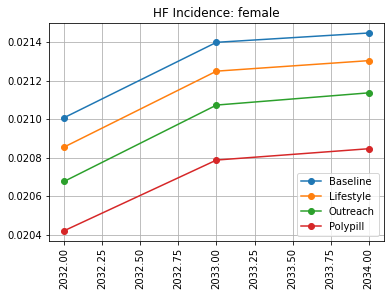

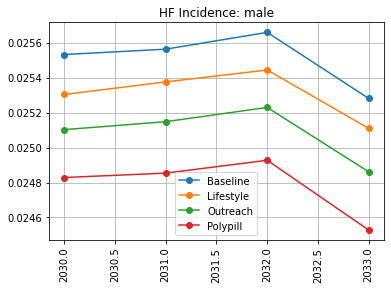

In [59]:
#%%capture
with PdfPages('model13_first_time_HF_inc_allages.pdf') as pdf:
    for sex in tran_rate_HF_summ.sex.unique():
            plt.figure() 
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.sex==sex) & (tran_rate_HF_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.sex==sex) & (tran_rate_HF_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.sex==sex) & (tran_rate_HF_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.sex==sex) & (tran_rate_HF_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'HF Incidence: {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            #plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

## Incidence in Count Space 

#### Start with Stroke 

In [60]:
tran_rate = tran.groupby(['sex', 'year', 'transition', 'input_draw','scenario']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate_sum = (tran_rate
                 .groupby(['sex', 'year','scenario'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,sex,year,scenario,mean,2.5%,97.5%
0,female,2023,baseline,562.2,464.375,691.875
1,female,2023,lifestyle_100,561.7,464.375,691.875
2,female,2023,lifestyle_50,562.2,464.375,691.875
3,female,2023,outreach_100,558.1,461.475,686.875
4,female,2023,outreach_50,560.5,463.700,690.100


In [61]:
%%capture
with PdfPages('model13_stroke_inc_count.pdf') as pdf:
    for sex in tran_rate_sum.sex.unique():
        plt.figure() 
        subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
        plt.title(f'Acute Stroke Incidence:{sex}') 
        plt.xticks(rotation=90) 
        plt.xlabel('Year')
        plt.ylabel('Stroke Counts')
        plt.grid()
        pdf.savefig(bbox_inches='tight')

In [62]:
tran_rate = tran.groupby(['sex', 'year', 'transition', 'input_draw','scenario']).value.sum().reset_index()
tran_rate_MI = tran_rate.loc[(tran_rate['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']))].reset_index()
tran_first_MI_summ = (tran_rate_MI
                 .groupby(['sex', 'year','scenario'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_first_MI_summ.head()

,sex,year,scenario,mean,2.5%,97.5%
0,female,2023,baseline,818.9,621.425,1077.450
1,female,2023,lifestyle_100,818.4,621.425,1076.675
2,female,2023,lifestyle_50,818.8,621.425,1077.450
3,female,2023,outreach_100,811.1,611.100,1072.550
4,female,2023,outreach_50,815.5,616.875,1074.000


In [63]:
%%capture
with PdfPages('model13_MI_inc_count.pdf') as pdf:
    for sex in tran_first_MI_summ.sex.unique():
        plt.figure() 
        subdata = tran_first_MI_summ.loc[(tran_first_MI_summ.sex==sex) & (tran_first_MI_summ.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = tran_first_MI_summ.loc[(tran_first_MI_summ.sex==sex) & (tran_first_MI_summ.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = tran_first_MI_summ.loc[(tran_first_MI_summ.sex==sex) & (tran_first_MI_summ.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = tran_first_MI_summ.loc[(tran_first_MI_summ.sex==sex) & (tran_first_MI_summ.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
        plt.title(f'Myocardial Infarction Incidence:{sex}') 
        plt.xticks(rotation=90) 
        plt.xlabel('Year')
        plt.ylabel('MI Counts')
        plt.grid()
        pdf.savefig(bbox_inches='tight')

In [64]:
tran_rate = tran.groupby(['sex', 'year', 'transition', 'input_draw','scenario']).value.sum().reset_index()
tran_rate_HF = tran_rate.loc[(tran_rate['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
tran_rate_HF_summ = (tran_rate_HF
                 .groupby(['sex', 'year','scenario'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_HF_summ.head()

,sex,year,scenario,mean,2.5%,97.5%
0,female,2023,baseline,1329.95,1115.450,1546.225
1,female,2023,lifestyle_100,1329.15,1115.450,1547.275
2,female,2023,lifestyle_50,1329.50,1114.925,1547.275
3,female,2023,outreach_100,1328.20,1113.400,1539.275
4,female,2023,outreach_50,1329.00,1114.775,1545.275


In [65]:
%%capture
with PdfPages('model13_HF_inc_count.pdf') as pdf:
    for sex in tran_rate_HF_summ.sex.unique():
        plt.figure() 
        subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.sex==sex) & (tran_rate_HF_summ.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.sex==sex) & (tran_rate_HF_summ.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.sex==sex) & (tran_rate_HF_summ.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.sex==sex) & (tran_rate_HF_summ.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
        plt.title(f'Heart Failure Incidence:{sex}') 
        plt.xticks(rotation=90) 
        plt.xlabel('Year')
        plt.ylabel('HF Counts')
        plt.grid()
        pdf.savefig(bbox_inches='tight')